# Customer Segmentation & Recommendation System

# Problem:
In this project, we delve deep into the thriving sector of online retail by analyzing a transactional dataset from a UK-based retailer, available at the UCI Machine Learning Repository. This dataset documents all transactions between 2010 and 2011. Our primary objective is to amplify the efficiency of marketing strategies and boost sales through customer segmentation. We aim to transform the transactional data into a customer-centric dataset by creating new features that will facilitate the segmentation of customers into distinct groups using the K-means clustering algorithm. This segmentation will allow us to understand the distinct profiles and preferences of different customer groups. Building upon this, we intend to develop a recommendation system that will suggest top-selling products to customers within each segment who haven't purchased those items yet, ultimately enhancing marketing efficacy and fostering increased sales.

# Importing Necessary Libraries

In [2]:
# Ignore warnings
!pip install yellowbrick

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [4]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [5]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

#  Loading the Dataset

In [6]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")


# Dataset Overview

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100247 entries, 0 to 100246
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    100247 non-null  object 
 1   StockCode    98706 non-null   object 
 2   Description  98407 non-null   object 
 3   Quantity     98706 non-null   float64
 4   InvoiceDate  98706 non-null   object 
 5   UnitPrice    98705 non-null   float64
 6   CustomerID   64581 non-null   float64
 7   Country      98705 non-null   object 
dtypes: float64(3), object(5)
memory usage: 6.1+ MB


Inferences:
The dataset consists of 100,247 entries and 8 columns. Here is a brief overview of each column:

- InvoiceNo: This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction.
- StockCode: An object data type column representing the product code for each item.
- Description: This column, also an object data type, contains descriptions of the products. 
- Quantity: This is an integer column indicating the quantity of products purchased in each transaction.
- InvoiceDate: A datetime column that records the date and time of each transaction.
- UnitPrice: A float column representing the unit price of each product.
- CustomerID: A float column that contains the customer ID for each transaction.
- Country: An object column recording the country where each transaction took place.

From a preliminary overview, it seems that there are missing values which need to be addressed.

# Summary Statistics

In [9]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,98706.0,8.917938,338.638616,-74215.0,1.00,3.00,8.00,74215.00
UnitPrice,98705.0,5.434923,121.680225,0.0,1.25,2.51,4.25,16888.02
CustomerID,64581.0,15353.780740,1769.435330,12346.0,13873.00,15311.00,17001.00,18283.00


In [10]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,100247,6200,537434,664
StockCode,98706,3061,85123A,535
Description,98407,2960,WHITE HANGING HEART T-LIGHT HOLDER,545
InvoiceDate,98706,4215,12/6/2010 16:57,664
Country,98705,29,United Kingdom,91128


# Handling Missing Values

Initially, I will determine the percentage of missing values present in each column, followed by selecting the most effective strategy to address them

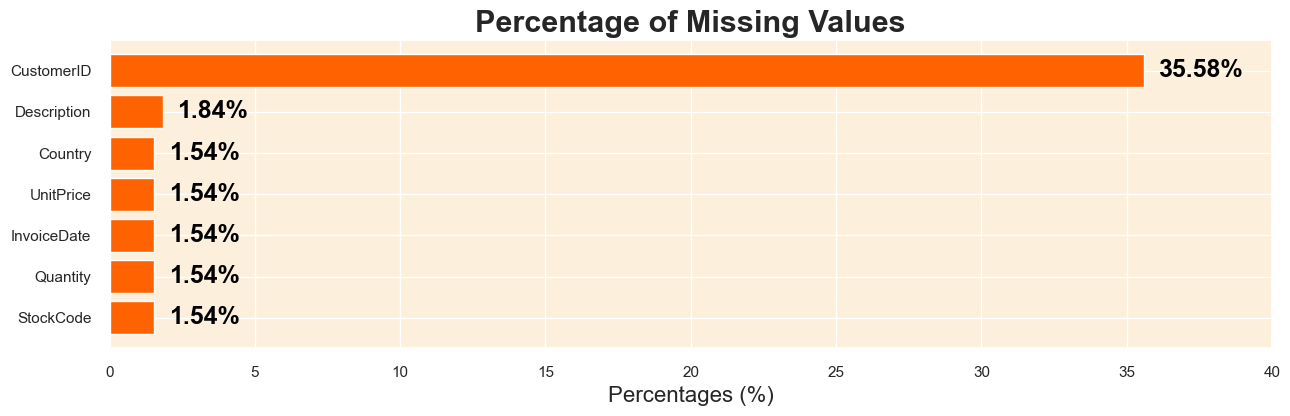

In [11]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

- The CustomerID column contains 35% missing data. This column is crucial for clustering customers and creating a recommendation system. Imputing missing values in such a large proportion may introduce significant bias or noise into the analysis. Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis
- Removing rows with missing Descriptions, Country, UnitPrice, InvoiceDate, Quantity, StockCode would be a wise measure to prevent the propagation of errors and inconsistencies into subsequent analyses.

In [12]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['CustomerID'].isnull() |df['Description'].isnull()|df['Country'].isnull()|df['UnitPrice'].isnull()  |df['StockCode'].isnull() |df['Quantity'].isnull() |df['StockCode'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
109,"536381,82567,""AIRLINE LOUNGE,METAL SIGN"",2,12/...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,"536394,21506,""FANCY FONT BIRTHDAY CARD, "",24,1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
622,536414,22139,NaN,56.0,12/1/2010 11:52,0.0,NaN,United Kingdom
871,"536477,22041,""RECORD FRAME 7"""" SINGLE SIZE "",4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
956,"536520,22760,""TRAY, BREAKFAST IN BED"",1,12/1/2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Removing rows with missing values in the columns
df = df.dropna(subset=['CustomerID','Description','Country','UnitPrice','StockCode','Quantity','StockCode'])

In [14]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64581 entries, 0 to 100226
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    64581 non-null  object 
 1   StockCode    64581 non-null  object 
 2   Description  64581 non-null  object 
 3   Quantity     64581 non-null  float64
 4   InvoiceDate  64581 non-null  object 
 5   UnitPrice    64581 non-null  float64
 6   CustomerID   64581 non-null  float64
 7   Country      64581 non-null  object 
dtypes: float64(3), object(5)
memory usage: 4.4+ MB


# Handling Duplicates

In [16]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom


Removing these rows will help in achieving a cleaner dataset, which in turn would aid in building more accurate customer clusters based on their unique purchasing behaviors. Moreover, it would help in creating a more precise recommendation system by correctly identifying the products with the most purchases.

In [17]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 903 duplicate rows that need to be removed.


In [18]:
# Getting the number of rows in the dataframe
df.shape[0]

63678

# Treating Cancelled Transactions

In [19]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,1744.000000,1744.000000
mean,-55.904817,8.268779
std,1791.058120,56.469241
min,-74215.000000,0.030000
25%,-6.000000,1.650000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,1715.850000


Strategy for Handling Cancelled Transactions:

Considering the project's objective to cluster customers based on their purchasing behavior and preferences and to eventually create a recommendation system, it's imperative to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations.

In [20]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.74%


# Correcting StockCode Anomalies

In [21]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 2700


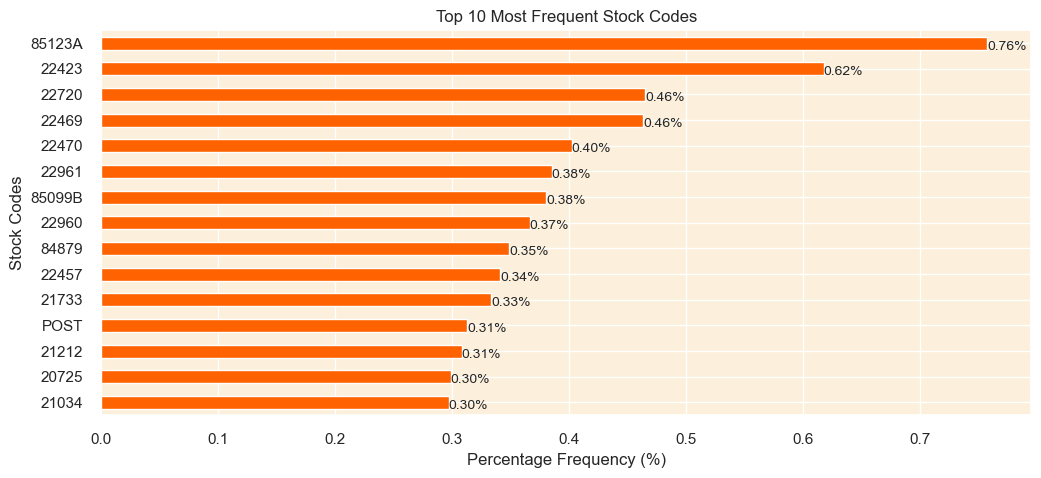

In [22]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(15) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

- Product Variety: The dataset contains 3684 unique stock codes, indicating a substantial variety of products available in the online retail store. This diversity can potentially lead to the identification of distinct customer clusters, with preferences for different types of products.
- Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products.

In [23]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    2695
0       4
1       1
Name: count, dtype: int64


In [24]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES


In [25]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.47%


Inference:

Based on the analysis, we find that a very small proportion of the records, 0.47%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes. Thus, the strategy would be to filter out and remove rows with these anomalous stock codes from the dataset before proceeding with further analysis and model development

In [26]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [27]:
# Getting the number of rows in the dataframe
df.shape[0]

63378

# Cleaning Description Column

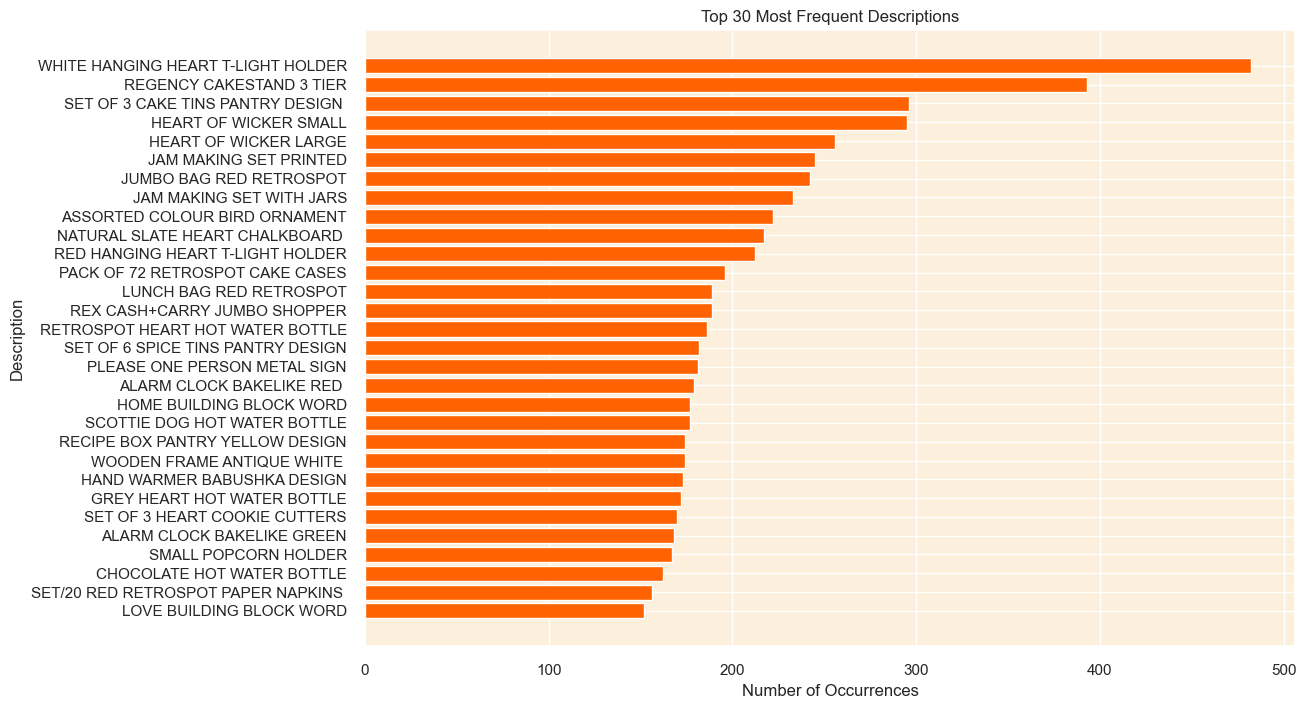

In [28]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

The most common descriptions are usually household items. All descriptions are written in uppercase, which may be a standard format for entering product descriptions into the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be wise to check if there are descriptions entered in lowercase or a combination of different case styles

In [29]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM


For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.

In [30]:
# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

In [31]:
# Getting the number of rows in the dataframe
df.shape[0]

63378

# Treating Zero Unit Prices

Check the general information of the Unit Price column

In [32]:
df['UnitPrice'].describe()

count    63378.000000
mean         3.141526
std          5.373015
min          0.000000
25%          1.250000
50%          1.950000
75%          3.750000
max        295.000000
Name: UnitPrice, dtype: float64

The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern

In [33]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,7.000000
mean,11.428571
std,10.097147
min,1.000000
25%,2.500000
50%,10.000000
75%,20.000000
max,24.000000


The transactions with a unit price of zero are relatively few in number (7 transactions). These transactions have a small variability in the quantity of items involved, ranging from 1 to 24. Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset.

In [34]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [35]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [36]:
# Getting the number of rows in the dataframe
df.shape[0]

63371

# Feature Engineering

Recency (R)

Days Since Last Purchas: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [37]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [38]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,36
1,12347.0,28
2,12348.0,29
3,12350.0,21
4,12352.0,7


Frequency (F)
In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:

- Total Transactions: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
- Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [39]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,36,2,0.0
1,12347.0,28,2,634.0
2,12348.0,29,2,1848.0
3,12350.0,21,1,196.0
4,12352.0,7,1,98.0


Monetary (M)
In this step, I am going to create two features that represent the monetary aspect of customer's transactions:

- Total Spend: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.
- Average Transaction Value: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [40]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,36,2,0.0,0.00,0.00
1,12347.0,28,2,634.0,1187.18,593.59
2,12348.0,29,2,1848.0,840.24,420.12
3,12350.0,21,1,196.0,294.40,294.40
4,12352.0,7,1,98.0,296.50,296.50


# Product Diversity

In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

- Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [41]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,36,2,0.0,0.00,0.00,1
1,12347.0,28,2,634.0,1187.18,593.59,49
2,12348.0,29,2,1848.0,840.24,420.12,17
3,12350.0,21,1,196.0,294.40,294.40,16
4,12352.0,7,1,98.0,296.50,296.50,15


# Behavioral Features

In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:

- Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.
- Favorite Shopping Day: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.
- Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [42]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]
# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,36,2,0.0,0.00,0.00,1,0.000000,1,10
1,12347.0,28,2,634.0,1187.18,593.59,49,0.847458,1,14
2,12348.0,29,2,1848.0,840.24,420.12,17,2.000000,3,19
3,12350.0,21,1,196.0,294.40,294.40,16,0.000000,2,16
4,12352.0,7,1,98.0,296.50,296.50,15,0.000000,2,12


# Geographic Features

Country: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [43]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.887015
Germany           0.025343
France            0.021871
EIRE              0.013729
Spain             0.008537
Name: proportion, dtype: float64

In [44]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,36,2,0.0,0.00,0.00,1,0.000000,1,10,1
1,12347.0,28,2,634.0,1187.18,593.59,49,0.847458,1,14,0
2,12348.0,29,2,1848.0,840.24,420.12,17,2.000000,3,19,0
3,12350.0,21,1,196.0,294.40,294.40,16,0.000000,2,16,0
4,12352.0,7,1,98.0,296.50,296.50,15,0.000000,2,12,0


In [45]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    1427
0     159
Name: count, dtype: int64

# Cancellation Insights

In this step, I am going to delve deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:

- Cancellation Frequency: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.
- Cancellation Rate: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

By incorporating these cancellation insights into our dataset, we can build a more comprehensive view of customer behavior, which could potentially aid in creating more effective and nuanced customer segmentation.

In [44]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,36,2,0.0,0.00,0.00,1,0.000000,1,10,1,1.0,0.5
1,12347.0,28,2,634.0,1187.18,593.59,49,0.847458,1,14,0,0.0,0.0
2,12348.0,29,2,1848.0,840.24,420.12,17,2.000000,3,19,0,0.0,0.0
3,12350.0,21,1,196.0,294.40,294.40,16,0.000000,2,16,0,0.0,0.0
4,12352.0,7,1,98.0,296.50,296.50,15,0.000000,2,12,0,0.0,0.0


- Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.
- Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.
- Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

In [46]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)
# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,36,2,0.0,0.00,0.00,1,0.000000,1,10,1,0.00,0.000000,0.00
1,12347.0,28,2,634.0,1187.18,593.59,49,0.847458,1,14,0,593.59,167.160043,-236.40
2,12348.0,29,2,1848.0,840.24,420.12,17,2.000000,3,19,0,420.12,329.059212,-465.36
3,12350.0,21,1,196.0,294.40,294.40,16,0.000000,2,16,0,294.40,0.000000,0.00
4,12352.0,7,1,98.0,296.50,296.50,15,0.000000,2,12,0,296.50,0.000000,0.00


In [47]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [48]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,36,2,0,0.0,0.0,1,0.0,1,10,1,0.0,0.0,0.0
1,12347.0,28,2,634,1187.18,593.59,49,0.847458,1,14,0,593.59,167.160043,-236.4
2,12348.0,29,2,1848,840.24,420.12,17,2.0,3,19,0,420.12,329.059212,-465.36
3,12350.0,21,1,196,294.4,294.4,16,0.0,2,16,0,294.4,0.0,0.0
4,12352.0,7,1,98,296.5,296.5,15,0.0,2,12,0,296.5,0.0,0.0
5,12356.0,36,1,1198,1947.62,1947.62,35,0.0,1,9,0,1947.62,0.0,0.0
6,12359.0,16,2,569,2369.61,1184.805,91,0.27957,0,14,0,1184.805,925.044162,1308.21
7,12362.0,6,1,226,434.1,434.1,26,0.0,3,10,0,434.1,0.0,0.0
8,12365.0,2,1,173,320.69,320.69,21,0.0,0,13,0,320.69,0.0,0.0
9,12370.0,68,2,940,1673.47,836.735,87,0.034884,1,12,0,1673.47,0.0,0.0


In [49]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      1586 non-null   string 
 1   Days_Since_Last_Purchase        1586 non-null   Int64  
 2   Total_Transactions              1586 non-null   Int64  
 3   Total_Products_Purchased        1586 non-null   Int64  
 4   Total_Spend                     1586 non-null   Float64
 5   Average_Transaction_Value       1586 non-null   Float64
 6   Unique_Products_Purchased       1586 non-null   Int64  
 7   Average_Days_Between_Purchases  1586 non-null   Float64
 8   Day_Of_Week                     1586 non-null   Int32  
 9   Hour                            1586 non-null   Int32  
 10  Is_UK                           1586 non-null   Int64  
 11  Monthly_Spending_Mean           1586 non-null   Float64
 12  Monthly_Spending_Std            15

# Outlier Detection and Treatment

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the Isolation Forest algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [50]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,36,2,0,0.0,0.0,1,0.0,1,10,1,0.0,0.0,0.0,1,0
1,12347.0,28,2,634,1187.18,593.59,49,0.847458,1,14,0,593.59,167.160043,-236.4,1,0
2,12348.0,29,2,1848,840.24,420.12,17,2.0,3,19,0,420.12,329.059212,-465.36,-1,1
3,12350.0,21,1,196,294.4,294.4,16,0.0,2,16,0,294.4,0.0,0.0,1,0
4,12352.0,7,1,98,296.5,296.5,15,0.0,2,12,0,296.5,0.0,0.0,1,0


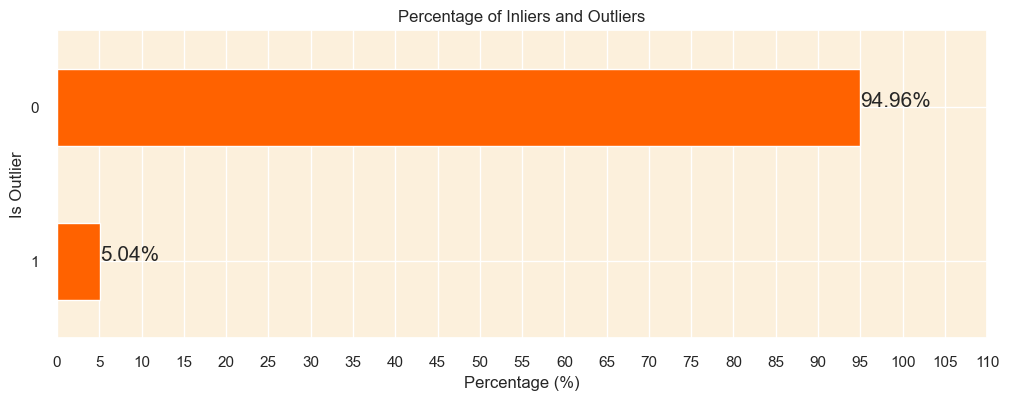

In [50]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

Considering the nature of the project (customer segmentation using clustering), it is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. Therefore, I will separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

In [51]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [52]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

1506

# Correlation Analysis

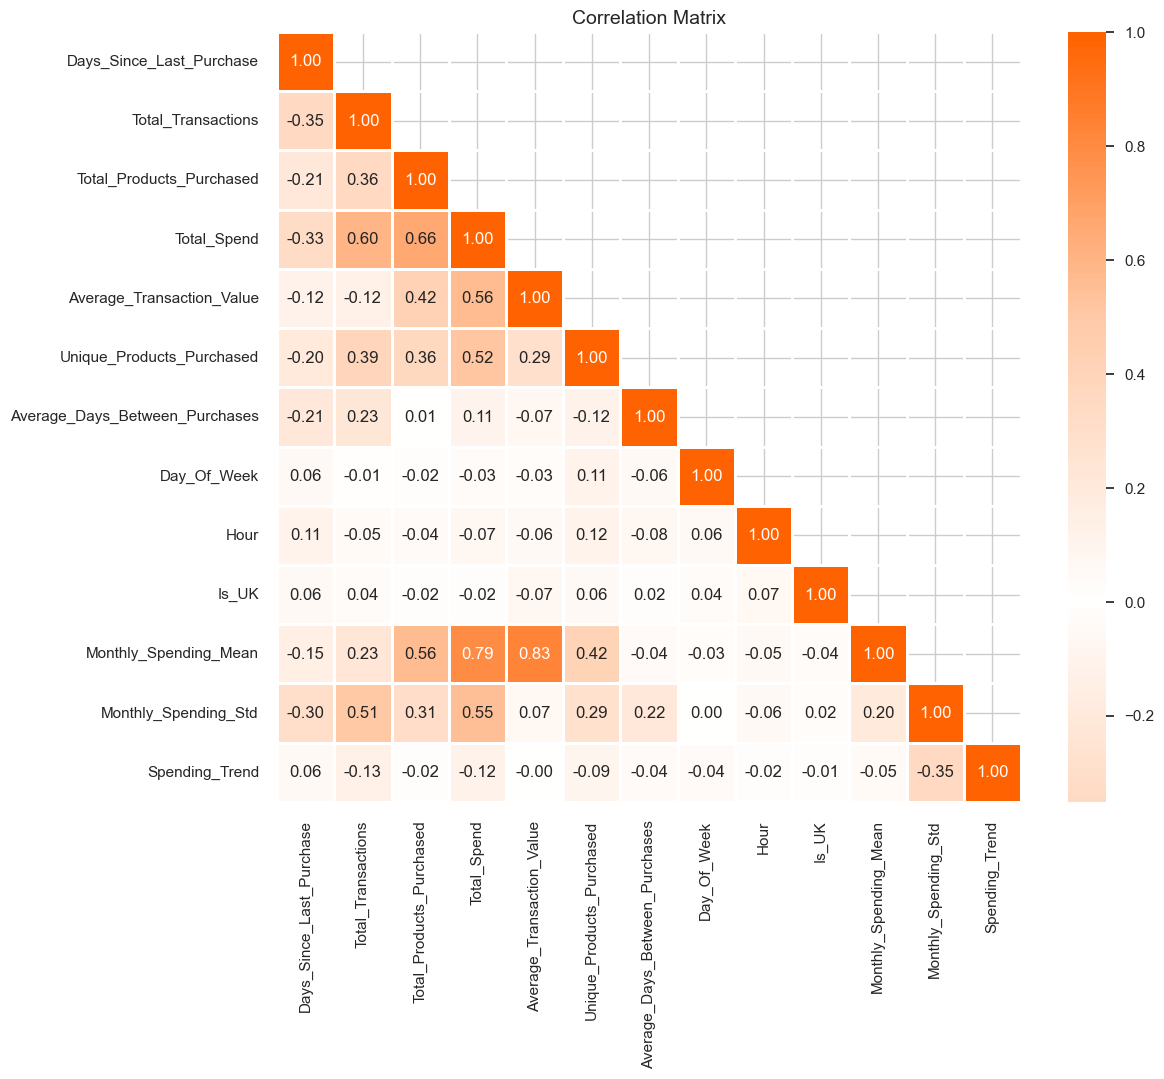

In [53]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

- Monthly_Spending_Mean and Average_Transaction_Value
- Total_Spend and Total_Products_Purchased
- Total_Transactions and Total_Spend
- Cancellation_Rate and Cancellation_Frequency
- Total_Transactions and Total_Products_Purchased

These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

# Feature Scaling

- For K-means Clustering: K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.
- For PCA: PCA aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.

In [55]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,-0.025931,-0.056246,-0.675966,-0.989325,-1.164686,-1.025085,-0.342711,1,-1.093894,1,-1.186487,-0.437751,0.106354
1,12347.0,-0.317905,-0.056246,0.791343,1.251584,1.355994,0.648841,0.042827,1,0.660530,0,0.795356,0.727204,-1.135479
2,12350.0,-0.573382,-0.628585,-0.222350,-0.433618,0.085484,-0.501983,-0.342711,2,1.537743,0,-0.203562,-0.437751,0.106354
3,12352.0,-1.084337,-0.628585,-0.449158,-0.429654,0.094402,-0.536857,-0.342711,2,-0.216682,0,-0.196551,-0.437751,0.106354
4,12362.0,-1.120834,-0.628585,-0.152919,-0.169922,0.678720,-0.153249,-0.342711,3,-1.093894,0,0.262860,-0.437751,0.106354


# Dimensionality Reduction

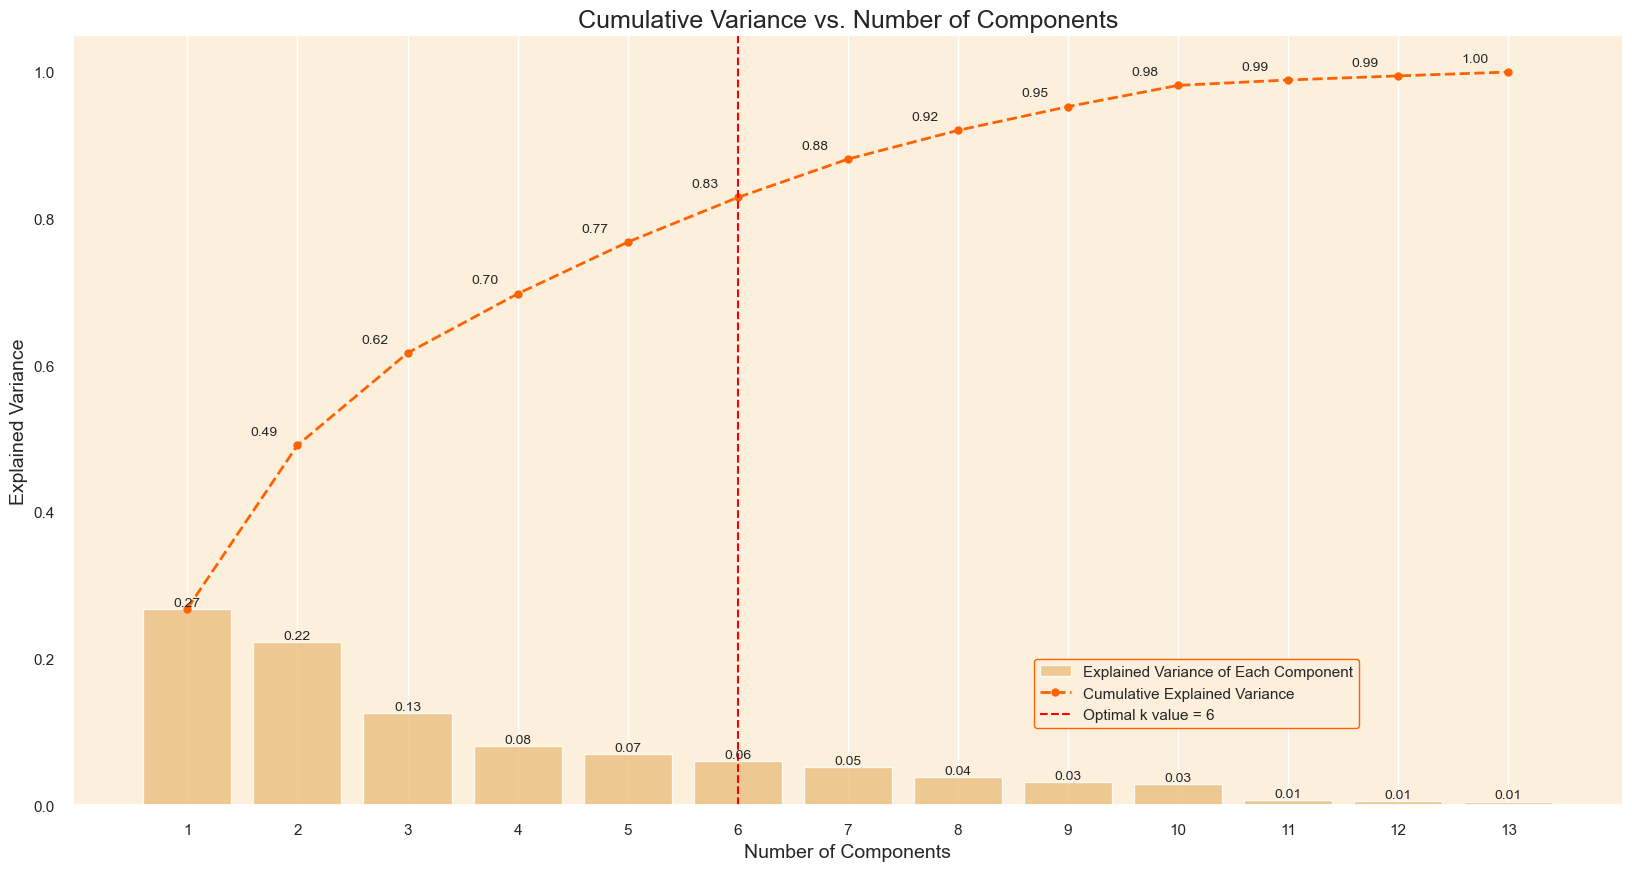

In [56]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)
# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200') 
# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

- The first component explains approximately 27% of the variance.

- The first two components together explain about 49% of the variance.

- The first three components explain approximately 62% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 83% of the total variance).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [57]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [58]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-1.953249,-1.613821,0.810218,0.562196,0.123326,-1.114424
12347.0,2.306329,-1.186296,-0.498085,-0.860280,0.934221,0.684051
12350.0,-0.778105,-0.426406,-0.465806,-0.768829,-0.373276,0.932769
12352.0,-0.675966,-0.546841,-0.197147,0.557300,0.074128,-0.110356
12362.0,0.039743,0.454257,-0.612065,1.300742,0.361999,-0.510711


Now, let's extract the coefficients corresponding to each principal component to better understand the transformation performed by PCA



In [59]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.225029,0.036635,-0.275618,-0.243163,0.188118,-0.012405
Total_Transactions,0.308080,0.016733,0.420030,-0.091169,-0.292854,-0.191082
Total_Products_Purchased,0.376549,0.017497,-0.112333,0.033649,-0.125034,-0.050474
Total_Spend,0.485186,0.016640,-0.018023,0.018731,-0.024445,0.013170
Average_Transaction_Value,0.311400,0.005046,-0.482184,0.168332,0.224150,0.238685
Unique_Products_Purchased,0.315873,0.110583,-0.043434,-0.356598,-0.231535,-0.210029
Average_Days_Between_Purchases,0.061745,-0.052447,0.389183,0.402729,-0.024978,0.683018
Day_Of_Week,-0.060564,0.988484,0.020028,0.124137,-0.002353,0.027373
Hour,-0.043313,0.053634,-0.061382,-0.681105,-0.287550,0.610647
Is_UK,-0.002695,0.007025,0.010869,-0.024163,-0.010456,0.004916


# K-Means Clustering

K-Means is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the within-cluster sum-of-squares (WCSS), also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

- Elbow Method

- Silhouette Method

It's common to utilize both methods in practice to corroborate the results.

# Elbow Method

What is the Elbow Method?

The Elbow Method is a technique for identifying the ideal number of clusters in a dataset. It involves iterating through the data, generating clusters for various values of k. The k-means algorithm calculates the sum of squared distances between each data point and its assigned cluster centroid, known as the inertia or WCSS score. By plotting the inertia score against the k value, we create a graph that typically exhibits an elbow shape, hence the name "Elbow Method". The elbow point represents the k-value where the reduction in inertia achieved by increasing k becomes negligible, indicating the optimal stopping point for the number of clusters.

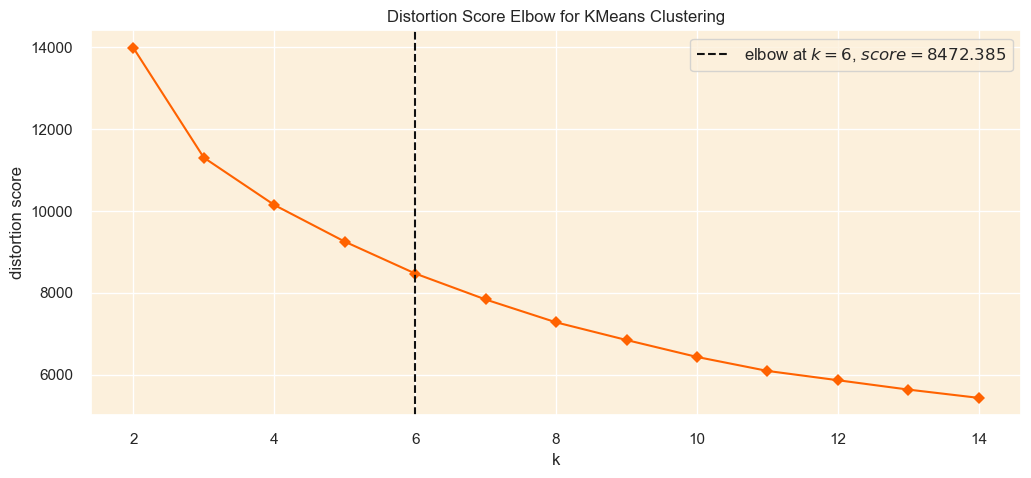

In [60]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

Optimal k Value: Elbow Method Insights

The optimal value of k for the KMeans clustering algorithm can be found at the elbow point. Using the YellowBrick library for the Elbow method, we observe that the suggested optimal k value is 6. However, we don't have a very distinct elbow point in this case, which is common in real-world data. From the plot, we can see that the inertia continues to decrease significantly up to k=6, indicating that the optimum value of k could be between 3 and 7. To choose the best k within this range, we can employ the silhouette analysis, another cluster quality evaluation method. Additionally, incorporating business insights can help determine a practical k value.

# Silhouette Method

What is the Silhouette Method?

The Silhouette Method is an approach to find the optimal number of clusters in a dataset by evaluating the consistency within clusters and their separation from other clusters. It computes the silhouette coefficient for each data point, which measures how similar a point is to its own cluster compared to other clusters.

What are the Advantages of Silhouette Method over the Elbow Method?

- The Silhouette Method evaluates cluster quality by considering both the cohesion within clusters and their separation from other clusters. This provides a more comprehensive measure of clustering performance compared to the Elbow Method, which only considers the inertia (sum of squared distances within clusters).
- The Silhouette Method produces a silhouette score that directly quantifies the quality of clustering, making it easier to compare different values of k. In contrast, the Elbow Method relies on the subjective interpretation of the elbow point, which can be less reliable in cases where the plot does not show a clear elbow.
- The Silhouette Method generates a visual representation of silhouette coefficients for each data point, allowing for easier identification of fluctuations and outliers within clusters. This helps in determining the optimal number of clusters with higher confidence, as opposed to the Elbow Method, which relies on visual inspection of the inertia plot.

In [61]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []
# Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
     # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

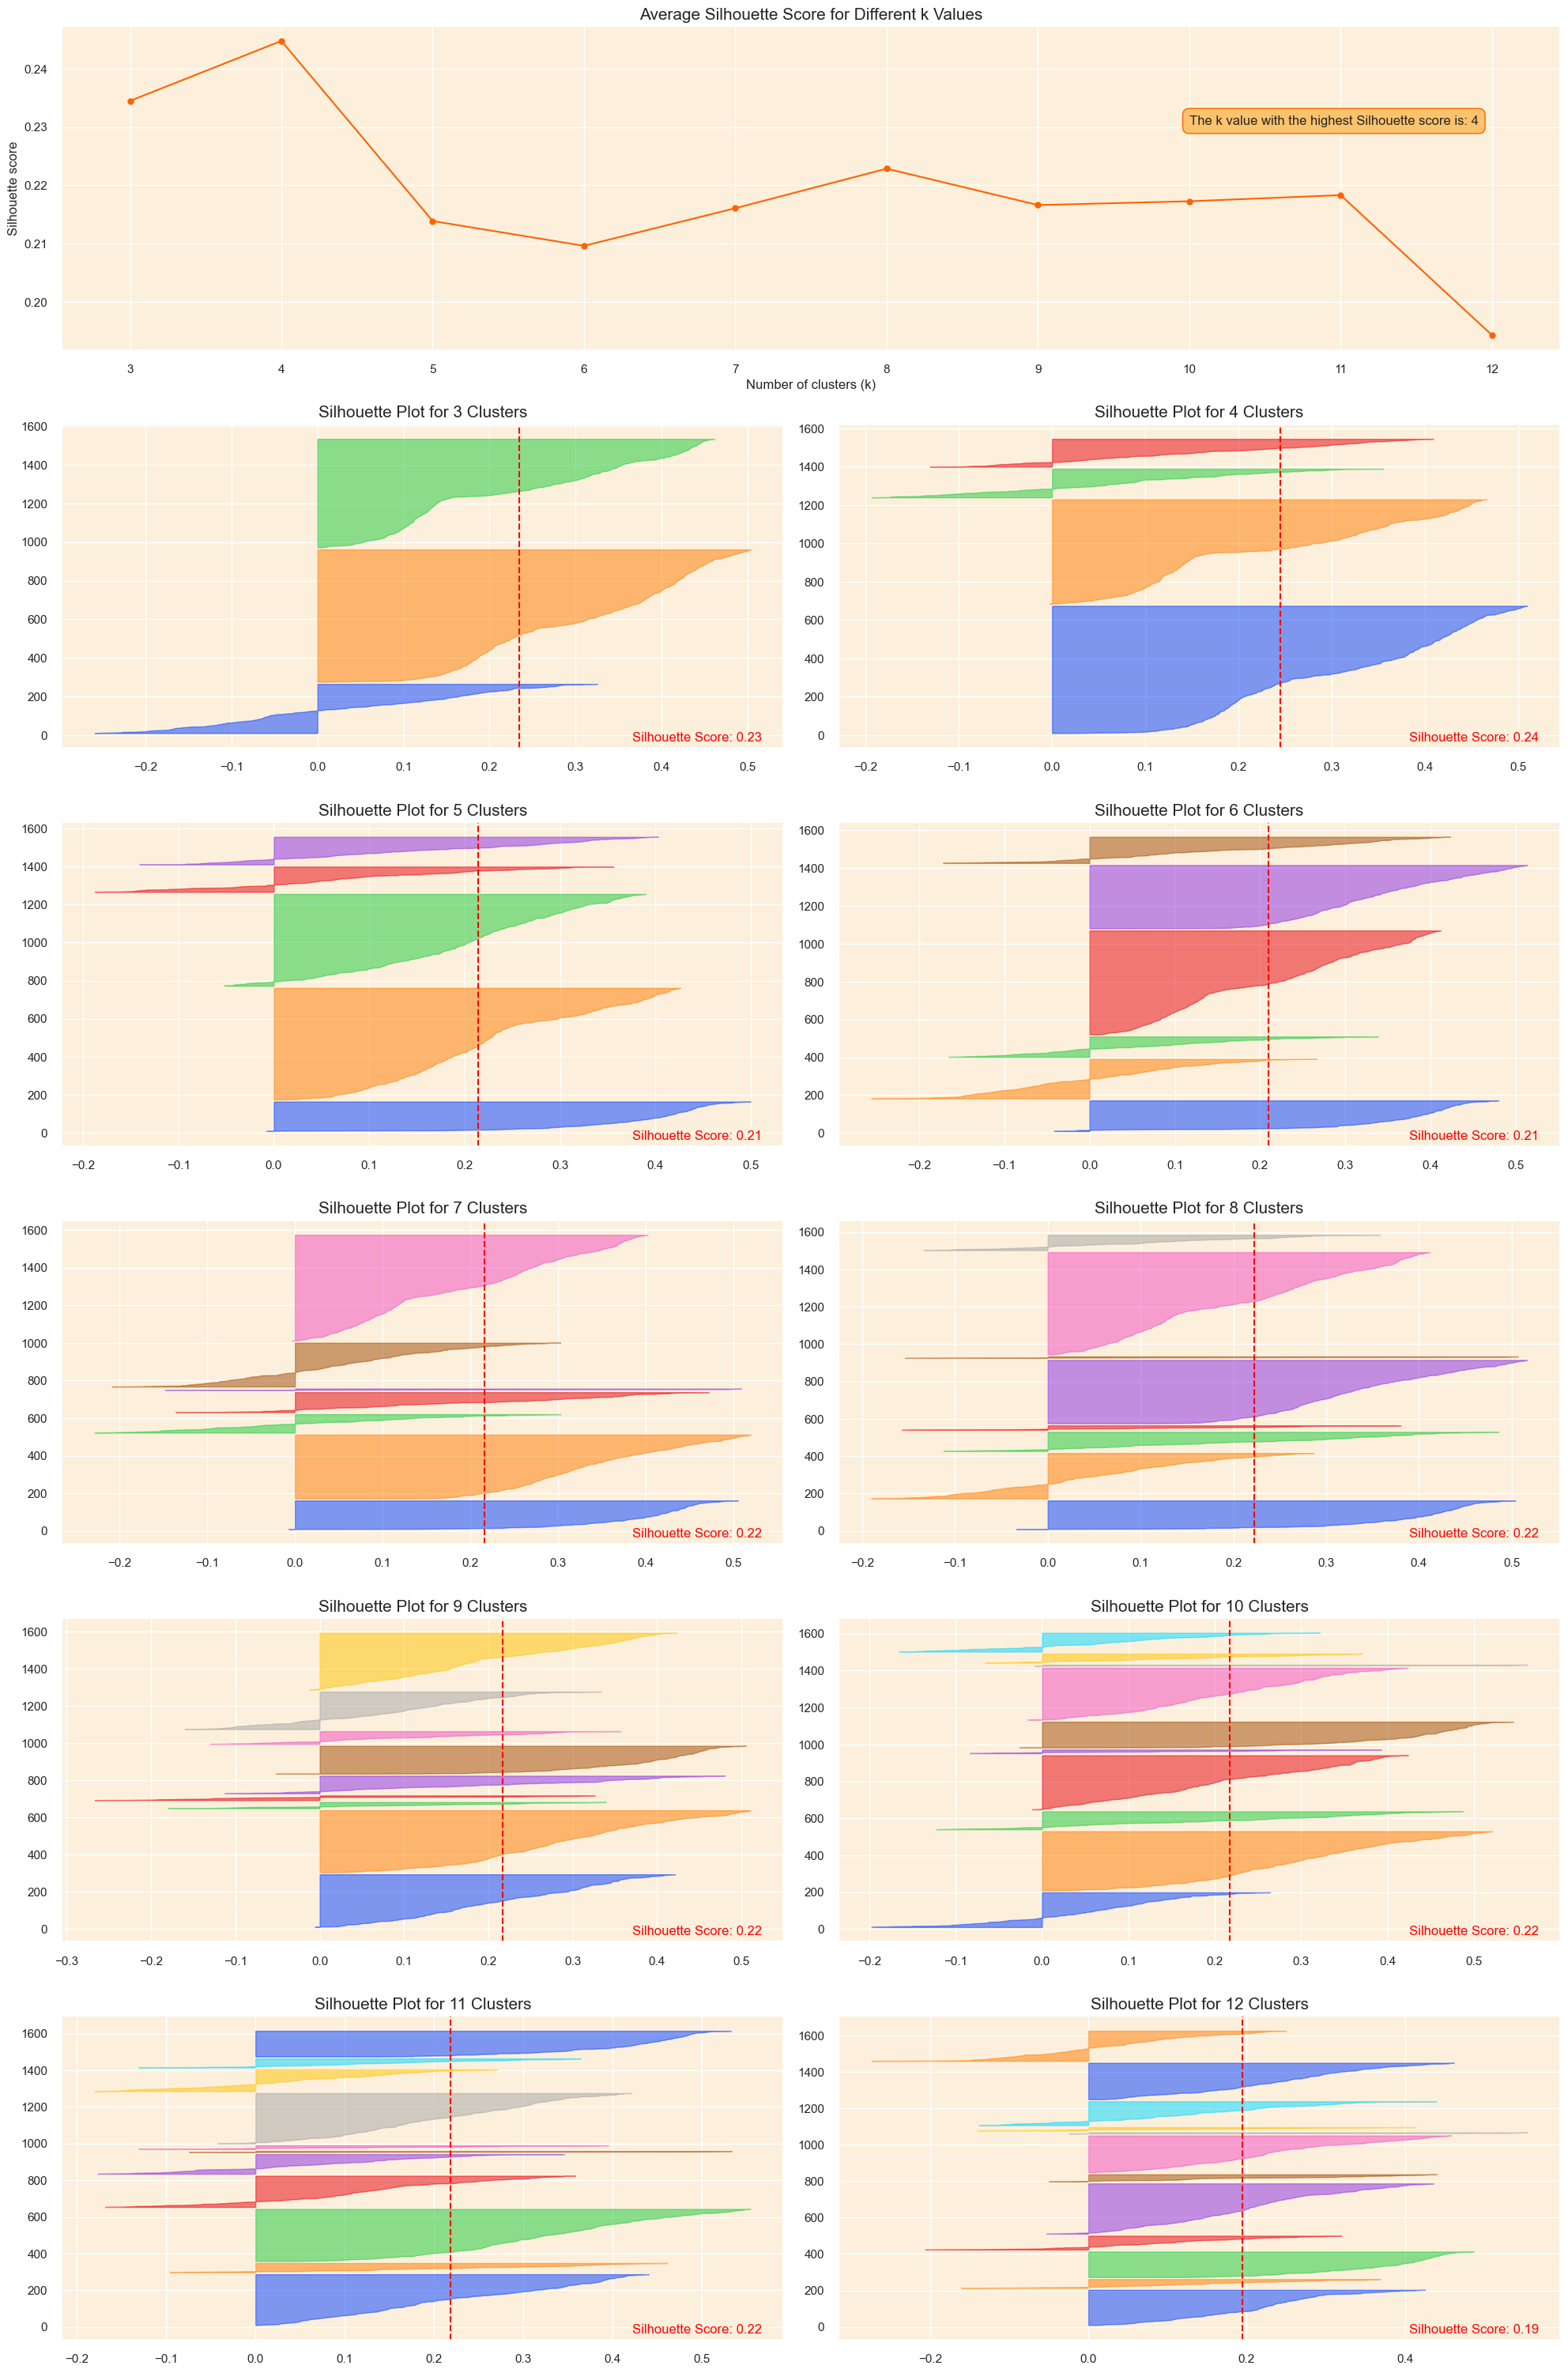

In [62]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

Guidelines to Interpret Silhouette Plots and Determine the Optimal K:

To interpret silhouette plots and identify the optimal number of clusters (( k )), consider the following criteria:

1️⃣ Analyze the Silhouette Plots:

Silhouette Score Width:

- Wide Widths (closer to +1): Indicate that the data points in the cluster are well separated from points in other clusters, suggesting well-defined clusters.
- Narrow Widths (closer to -1): Show that data points in the cluster are not distinctly separated from other clusters, indicating poorly defined clusters.
Average Silhouette Score:

- High Average Width: A cluster with a high average silhouette score indicates well-separated clusters.
- Low Average Width: A cluster with a low average silhouette score indicates poor separation between clusters.

2️⃣ Uniformity in Cluster Size:

2.1 Cluster Thickness:

- Uniform Thickness: Indicates that clusters have a roughly equal number of data points, suggesting a balanced clustering structure.
- Variable Thickness: Signifies an imbalance in the data point distribution across clusters, with some clusters having many data points and others too few.

3️⃣ Peaks in Average Silhouette Score:
- Clear Peaks: A clear peak in the average silhouette score plot for a specific ( k ) value indicates this ( k ) might be optimal.

4️⃣ Minimize Fluctuations in Silhouette Plot Widths:
- Uniform Widths: Seek silhouette plots with similar widths across clusters, suggesting a more balanced and optimal clustering.
- Variable Widths: Avoid wide fluctuations in silhouette plot widths, indicating that clusters are not well-defined and may vary in compactness.

5️⃣ Optimal Cluster Selection:
- Maximize the Overall Average Silhouette Score: Choose the ( k ) value that gives the highest average silhouette score across all clusters, indicating well-defined clusters.
- Avoid Below-Average Silhouette Scores: Ensure most clusters have above-average silhouette scores to prevent suboptimal clustering structures.

6️⃣ Visual Inspection of Silhouette Plots:
- Consistent Cluster Formation: Visually inspect the silhouette plots for each ( k ) value to evaluate the consistency and structure of the formed clusters.
- Cluster Compactness: Look for more compact clusters, with data points having silhouette scores closer to +1, indicating better clustering.


Optimal k Value: Silhouette Method Insights

Based on above guidelines and after carefully considering the silhouette plots, it's clear that choosing ( k = 3 ) is the better option. This choice gives us clusters that are more evenly matched and well-defined, making our clustering solution stronger and more reliable.

# Clustering Model - K-means

In this step, I am going to apply the K-means clustering algorithm to segment customers into different clusters based on their purchasing behaviors and other characteristics, using the optimal number of clusters determined in the previous step.

It's important to note that the K-means algorithm might assign different labels to the clusters in each run. To address this, we have taken an additional step to swap the labels based on the frequency of samples in each cluster, ensuring a consistent label assignment across different runs.

In [63]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [64]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,36,2,0,0.0,0.0,1,0.0,1,10,1,0.0,0.0,0.0,2
1,12347.0,28,2,634,1187.18,593.59,49,0.847458,1,14,0,593.59,167.160043,-236.4,1
2,12350.0,21,1,196,294.4,294.4,16,0.0,2,16,0,294.4,0.0,0.0,2
3,12352.0,7,1,98,296.5,296.5,15,0.0,2,12,0,296.5,0.0,0.0,2
4,12362.0,6,1,226,434.1,434.1,26,0.0,3,10,0,434.1,0.0,0.0,0


# 3D Visualization of Top Principal Components

In this part, I am going to choose the top 3 PCs (which capture the most variance in the data) and use them to create a 3D visualization. This will allow us to visually inspect the quality of separation and cohesion of clusters to some extent:

In [65]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [66]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

# Cluster Distribution Visualization

I am going to utilize a bar plot to visualize the percentage of customers in each cluster, which helps in understanding if the clusters are balanced and significant:

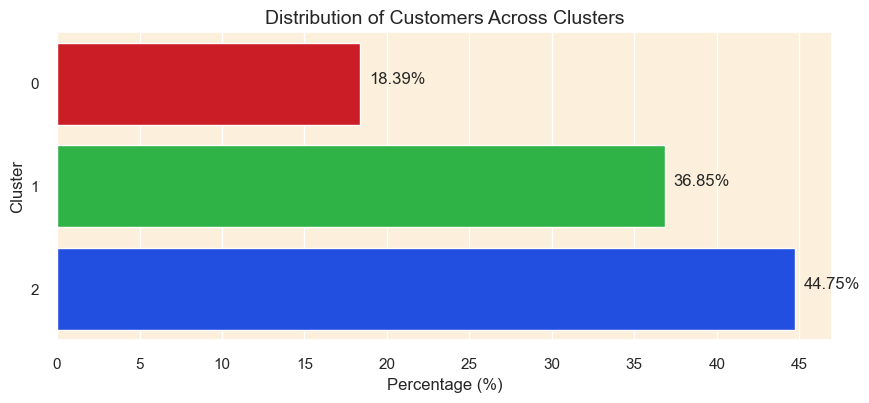

In [66]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

The distribution of customers across the clusters, as depicted by the bar plot, suggests a fairly balanced distribution with cluster 0 holding approximately 19% of customers, cluster 1 accommodating around 37%, and cluster 2 containing about 45% of customers.

This balanced distribution indicates that our clustering process has been largely successful in identifying meaningful patterns within the data, rather than merely grouping noise or outliers. It implies that each cluster represents a substantial and distinct segment of the customer base, thereby offering valuable insights for future business strategies.

Moreover, the fact that no cluster contains a very small percentage of customers, assures us that each cluster is significant and not just representing outliers or noise in the data. This setup allows for a more nuanced understanding and analysis of different customer segments, facilitating effective and informed decision-making.

# Evaluation Metrics

In [67]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        1506        |
|    Silhouette Score     | 0.2344759479280317 |
| Calinski Harabasz Score | 427.29976678591885 |
|  Davies Bouldin Score   | 1.383801241465162  |
+-------------------------+--------------------+


- The Silhouette Score of approximately 0.234, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.
- The Calinski Harabasz Score is 427.3, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.
- The Davies Bouldin Score of 1.38 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.

In conclusion, the metrics suggest that the clustering is of good quality, with clusters being well-defined and fairly separated. However, there might still be room for further optimization to enhance cluster separation and definition, potentially by trying other clustering and dimensionality reduction algorithms.

# Radar Chart Approach

First of all, I am going to create radar charts to visualize the centroid values of each cluster across different features. This can give a quick visual comparison of the profiles of different clusters.To construct the radar charts, it's essential to first compute the centroid for each cluster. This centroid represents the mean value for all features within a specific cluster. Subsequently, I will display these centroids on the radar charts, facilitating a clear visualization of the central tendencies of each feature across the various clusters

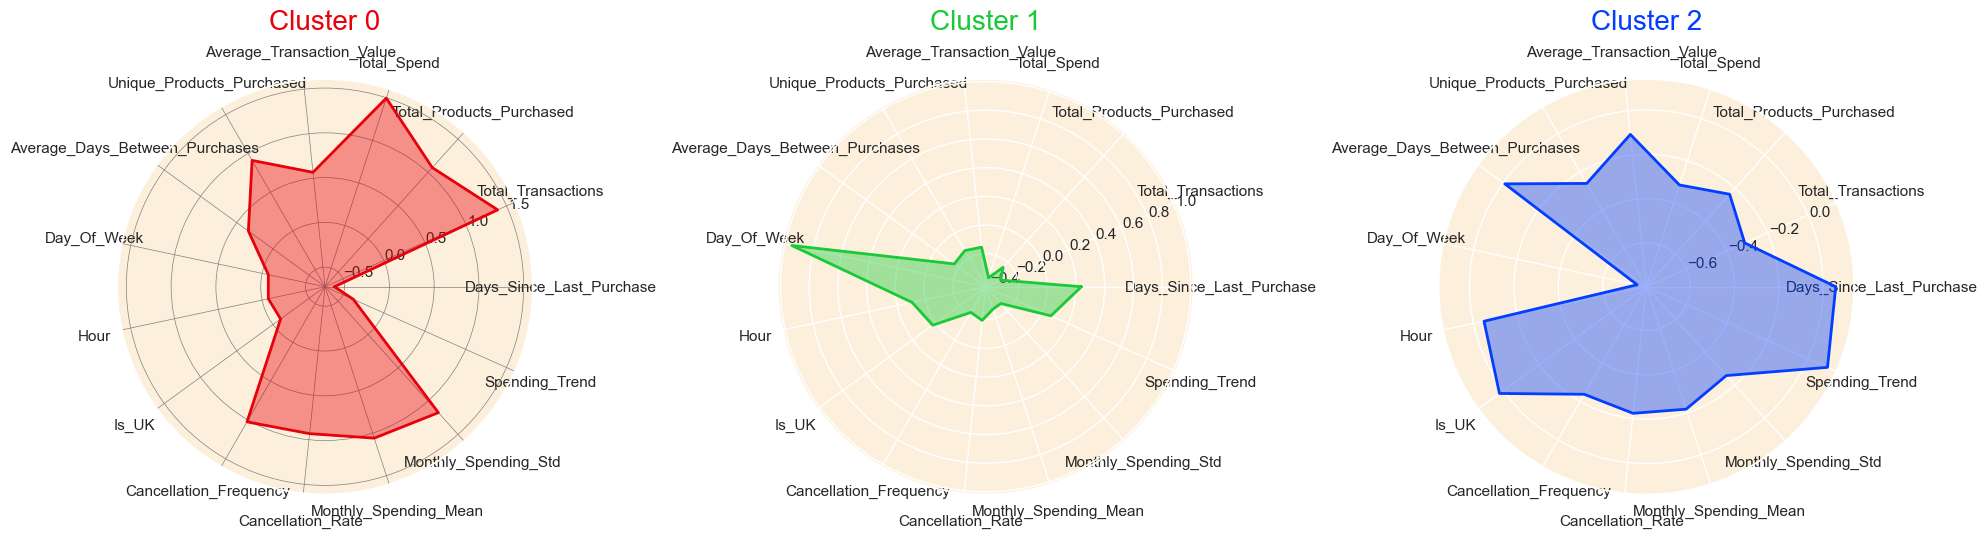

In [69]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)
# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])
ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


Customer Profiles Derived from Radar Chart Analysis

Cluster 0 (Red Chart):
🎯 Profile: Sporadic Shoppers with a Preference for Weekend Shopping

- Customers in this cluster tend to spend less, with a lower number of transactions and products purchased.
- They have a slight tendency to shop during the weekends, as indicated by the very high Day_of_Week value.
- Their spending trend is relatively stable but on the lower side, and they have a low monthly spending variation (low Monthly_Spending_Std).
- These customers have not engaged in many cancellations, showing a low cancellation frequency and rate.
- The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.

Cluster 1 (Green Chart):
🎯 Profile: Infrequent Big Spenders with a High Spending Trend

- Customers in this cluster show a moderate level of spending, but their transactions are not very frequent, as indicated by the high Days_Since_Last_Purchase and Average_Days_Between_Purchases.
- They have a very high spending trend, indicating that their spending has been increasing over time.
- These customers prefer shopping late in the day, as indicated by the high Hour value, and they mainly reside in the UK.
- They have a tendency to cancel a moderate number of transactions, with a medium cancellation frequency and rate.
- Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.

Cluster 2 (Blue Chart):
🎯 Profile: Frequent High-Spenders with a High Rate of Cancellations

- Customers in this cluster are high spenders with a very high total spend, and they purchase a wide variety of unique products.
- They engage in frequent transactions, but also have a high cancellation frequency and rate.
- These customers have a very low average time between purchases, and they tend to shop early in the day (low Hour value).
- Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.
- Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.

# Histogram Chart Approach

To validate the profiles identified from the radar charts, we can plot histograms for each feature segmented by the cluster labels. These histograms will allow us to visually inspect the distribution of feature values within each cluster, thereby confirming or refining the profiles we have created based on the radar charts.

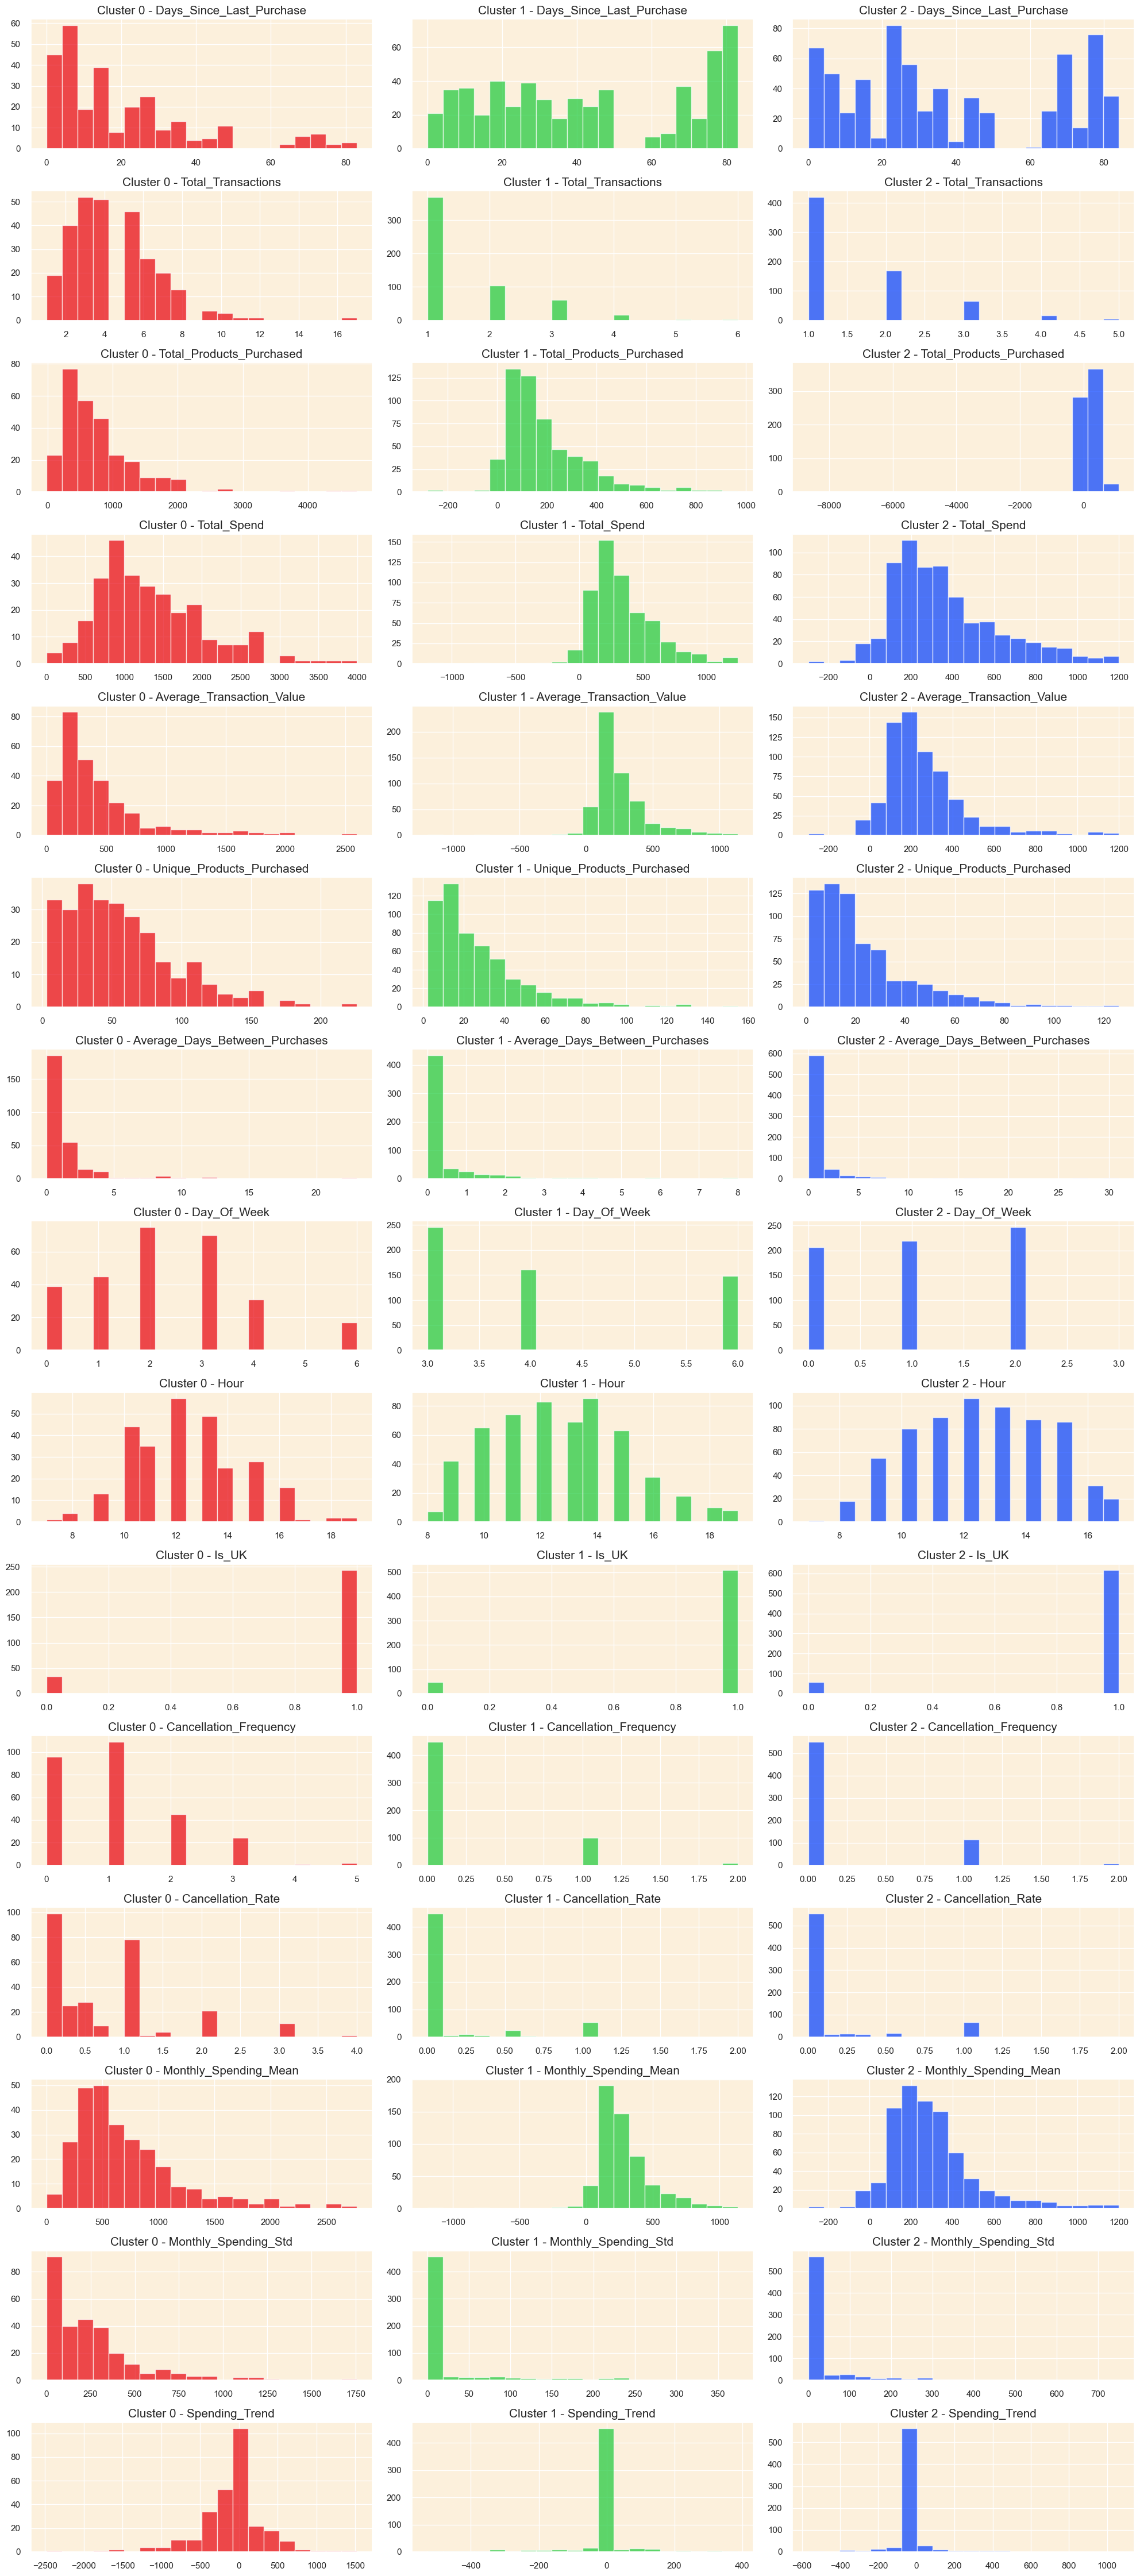

In [70]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

The detailed insights from the histograms provide a more nuanced understanding of each cluster, helping in refining the profiles to represent the customer behaviors more accurately. Based on the detailed analysis from both the radar charts and the histograms, here are the refined profiles and titles for each cluster

Cluster 0 - Casual Weekend Shoppers:
- Customers in this cluster usually shop less frequently and spend less money compared to the other clusters.
- They generally have a smaller number of transactions and buy fewer products.
- These customers have a preference for shopping during the weekends, possibly engaging in casual or window shopping.
- Their spending habits are quite stable over time, showing little fluctuation in their monthly spending.
- They rarely cancel their transactions, indicating a more decisive shopping behavior.
- When they do shop, their spending per transaction tends to be lower compared to other clusters.

Cluster 1 - Occasional Big Spenders:
- Customers in this cluster don't shop frequently but tend to spend a considerable amount when they do, buying a variety of products.
- Their spending has been on the rise, indicating a growing interest or investment in their purchases.
- They prefer to shop later in the day, possibly after work hours, and are mainly based in the UK.
- They have a moderate tendency to cancel transactions, which might be due to their higher spending; they perhaps reconsider their purchases more often.
- Their purchases are generally substantial, indicating a preference for quality or premium products.

Cluster 2 - Eager Early-Bird Shoppers:
- Customers in this cluster are characterized by their high spending habits. They tend to buy a wide array of unique products and engage in numerous transactions.
- Despite their high expenditure, they have a tendency to cancel a significant portion of their transactions, possibly indicating impulsive buying behaviors.
- They usually shop during the early hours of the day, perhaps finding time before their daily commitments or taking advantage of early bird deals.
- Their spending patterns are quite variable, with high fluctuations in their monthly spending, indicating a less predictable shopping pattern.
- Interestingly, their spending trend is showing a slight decrease, which might signal a future change in their shopping habits.




# Recommendation System

In the final phase of this project, I am set to develop a recommendation system to enhance the online shopping experience. This system will suggest products to customers based on the purchasing patterns prevalent in their respective clusters. Earlier in the project, during the customer data preparation stage, I isolated a small fraction (5%) of the customers identified as outliers and reserved them in a separate dataset called outliers_data.

Now, focusing on the core 95% of the customer group, I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting the top three products popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. For the outlier group, a basic approach could be to recommend random products, as a starting point to engage them.

In [71]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)
# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())
        # Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [72]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
12872.0,22492,MINI PAINT SET VINTAGE,21212,PACK OF 72 RETROSPOT CAKE CASES,85099B,JUMBO BAG RED RETROSPOT
13263.0,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE,21212,PACK OF 72 RETROSPOT CAKE CASES
12410.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22492,MINI PAINT SET VINTAGE,21212,PACK OF 72 RETROSPOT CAKE CASES
16317.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17003,BROCADE RING PURSE
17682.0,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE,21212,PACK OF 72 RETROSPOT CAKE CASES
17849.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17003,BROCADE RING PURSE
12662.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22492,MINI PAINT SET VINTAGE,21212,PACK OF 72 RETROSPOT CAKE CASES
14388.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22492,MINI PAINT SET VINTAGE,21212,PACK OF 72 RETROSPOT CAKE CASES
16835.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17003,BROCADE RING PURSE
